<a href="https://colab.research.google.com/github/jrakhshanda/Text-Mining/blob/main/text_mining.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tweet Sentiment Extraction

In [ ]:
!pip install tokenizers
!pip install transformers
!pip install wordsegment
#!pip install setuptools_rust
#!curl https://raw.githubusercontent.com/pytorch/xla/master/contrib/scripts/env-setup.py -o pytorch-xla-env-setup.py
#!python pytorch-xla-env-setup.py --version nightly --apt-packages libomp5 libopenblas-dev

In [34]:
import pandas as pd
import numpy as np
import string
import matplotlib.pyplot as plt
#import pytorch_utils

from sklearn import model_selection, metrics
import re
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, dataset, RandomSampler, SequentialSampler

import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

#from transformers import *
#import tokenizers
#from tokenizers import BertWordPieceTokenizer, ByteLevelBPETokenizer

import warnings
warnings.filterwarnings("ignore")


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [3]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [5]:
df_train = pd.read_csv('/content/drive/MyDrive/RoBERTa_files/train.csv',keep_default_na=False).reset_index(drop=True)
#df_test = pd.read_csv('/content/drive/MyDrive/test.csv',keep_default_na=False).reset_index(drop=True)


In [6]:
max_len =  [len(i) for i in df_train.text]
np.max(max_len)

141

## Creating fold of data
ectracting out 10% data for testing and then creating 5 folds of data to train our model using cross validation. we will use one fold for validation and train model using other folds. 

In [7]:
#df, test = model_selection.train_test_split(df_train,test_size=0.2)
#test.to_csv('/content/drive/MyDrive/BERT_files/test_fold.csv')

#df["kfold"] = -1
#df = df.sample(frac=1).reset_index(drop=True)

#kf = model_selection.StratifiedKFold(n_splits=5)

#for fold, (trn_, val_) in enumerate(kf.split(X=df, y=df.sentiment.values)):
#    print(len(trn_), len(val_))
#    df.loc[val_, 'kfold'] = fold

#df.to_csv("/content/drive/MyDrive/BERT_files/train_folds.csv", index=False)
#test.to_csv("/content/drive/MyDrive/BERT_files/test_fold.csv", index=False)

Text(0.5, 1.0, 'Training Data')

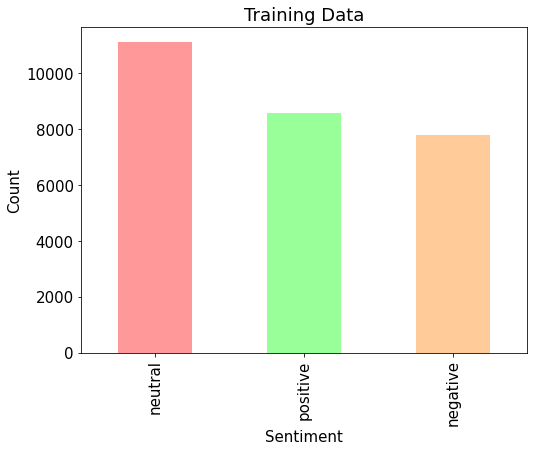

In [13]:
plt.rcParams.update({'font.size': 15})
plt.figure(figsize=(8,6))
df_train["sentiment"].value_counts().plot(kind='bar',color = ['#ff9999','#99ff99','#ffcc99'])
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.title('Training Data')



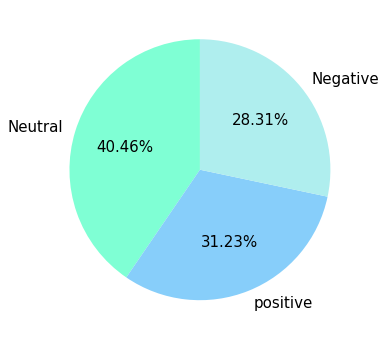

In [32]:
plt.rcParams.update({'font.size': 15})
plt.figure(figsize=(6,6))
lst1 = [df_train.sentiment[df_train.sentiment == 'neutral'].count(),
        df_train.sentiment[df_train.sentiment == 'positive'].count(),
        df_train.sentiment[df_train.sentiment == 'negative'].count()]
        
plt.pie(lst1, labels=["Neutral", "positive", "Negative"], startangle=90, autopct='%.2f%%',colors=['aquamarine','lightskyblue','paleturquoise'])
plt.show()

In [ ]:
print(df_test.shape)
df_test.sample(6)

(3534, 3)


,textID,text,sentiment
689,1620bd719e,All done. No more internship.,neutral
2890,089f2af7b9,i wish i could go to meet in the middle tomorrow.,positive
2102,4fb0995de8,Hows that possible? No rain forecast for Pinkp...,neutral
2129,d24c474353,I know it`s against the law... I am a rebel i...,positive
672,10f2498c35,I want Crimson Gem Saga. I will just go play ...,neutral
156,14760477ad,is pretty dang tired. but chambers class is fo...,negative


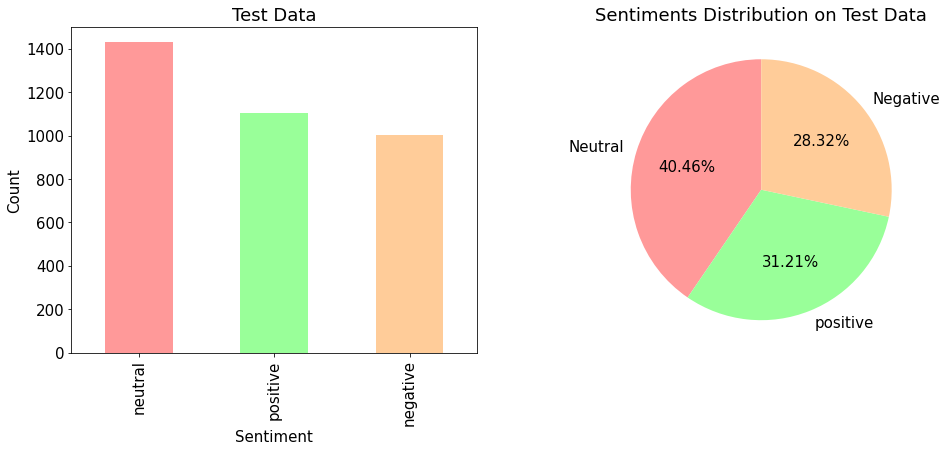

In [ ]:
plt.rcParams.update({'font.size': 15})
plt.figure(figsize=(16,6))
plt.subplot(1, 2, 1)
df_test["sentiment"].value_counts().plot(kind='bar',color = ['#ff9999','#99ff99','#ffcc99'])
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.title('Test Data')

lst1 = [df_test.sentiment[df_test.sentiment == 'neutral'].count(),
        df_test.sentiment[df_test.sentiment == 'positive'].count(),
        df_test.sentiment[df_test.sentiment == 'negative'].count()]
plt.subplot(1, 2, 2)
plt.pie(lst1, labels=["Neutral", "positive", "Negative"], startangle=90, autopct='%.2f%%',colors=['#ff9999','#99ff99','#ffcc99'])
plt.title('Sentiments Distribution on Test Data')
plt.show()

## Constructing Sentiments Cloud
[code refrence](https://quantdare.com/introduction-to-nlp-sentiment-analysis-and-wordclouds/)

In [39]:
def classify_compound(text, threshold=0.33):
     
    # initialize VADER
    sid = SentimentIntensityAnalyzer()
     
    # Calling the polarity_scores method on sid and passing in the text
    # outputs a dictionary with negative, neutral, positive, and compound scores for the input text
    scores = sid.polarity_scores(text)
     
    # get compound score
    score = scores['compound']
     
    # translate the score into the correcponding input according to the threshold
    if score <= -threshold: return 'negative'
    elif score >= threshold: return 'positive'
    else: return 'neutral'

In [40]:
df = df_train
# create a new feature based on compound score from VADER using our function "classify_compound"
df['compound_sentiment'] = df.text.apply(lambda text: classify_compound(text))

In [41]:
pd.concat([df.sentiment.value_counts(),df.compound_sentiment.value_counts()], axis=1, sort='True')

,sentiment,compound_sentiment
negative,7781,4471
neutral,11118,11833
positive,8582,11177


In [ ]:
mask_differents = df.sentiment != df.compound_sentiment
differences = df[mask_differents]
print('There are {:.2%} different values between Sentiment and Compound Sentiment'.format(differences.shape[0] / df.shape[0]))
print('Showing 5 random rows with different original sentiment and compound sentiment:')
differences.sample(5)

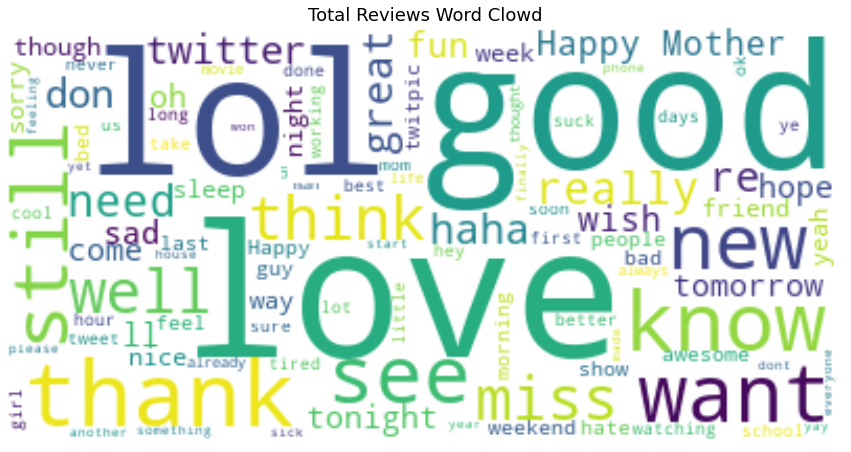

In [90]:
from wordcloud import  WordCloud, STOPWORDS, ImageColorGenerator
 
# Get stopwords from wordcloud library
stopwords = set(STOPWORDS)
 
# Add some extra words ad hoc for our purpose
app_words = ['app', 'apps', 'application', 'game','http','now','im','say','go','didnt','going','got',
             'will','ve','make','back','one','today','work','gonna','day','time','much','home','didn',
             'look','right','even','thing','getting']
stopwords.update(app_words)
 
# join all reviews
text = " ".join(review for review in df.text)
 
# Generate the image
wordcloud = WordCloud(stopwords=stopwords, background_color="white", max_words=100).generate(text)
 
# visualize the image
fig=plt.figure(figsize=(15, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Total Reviews Word Clowd')
plt.show()

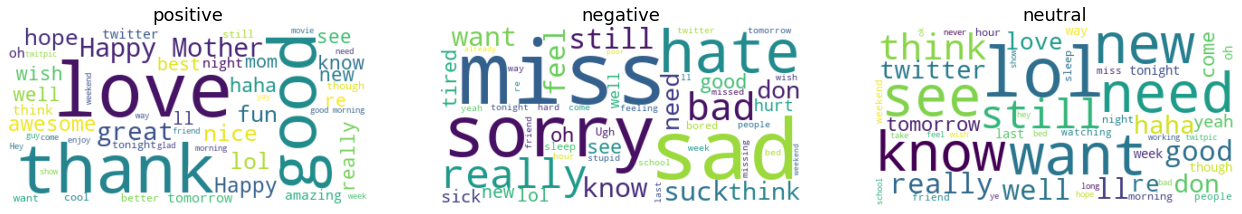

In [91]:
plt.rcParams.update({'font.size': 15})
plt.figure(figsize=(22,6))
for i , sentiment in enumerate(['positive','negative','neutral']):
  text = " ".join(review for review in df.text[df.sentiment == sentiment])
  word_cloud = WordCloud(stopwords=stopwords, background_color="white", max_words=50).generate(text)
  plt.subplot(1, 3, i+1)
  plt.imshow(word_cloud, interpolation='bilinear', alpha=1)
  plt.axis("off")
  plt.title(sentiment)  

## Cleaning of the Data

In [ ]:
# removig punctuation
def clean_data(text):

  # removing punctuation
  text  = " ".join([char for char in text if char not in string.punctuation]).strip()
  # removing digits
  text = re.sub('[0-9]+', '', text)
  # removing URL 
  text = re.sub(r'http\S+', '', text) 
  
  return text


In [ ]:
df_train['text'] = df_train['text'].apply(lambda x: clean_data(x))
df_train['selected_text'] = df_train['selected_text'].apply(lambda x: clean_data(x))
df_test[''] = df_test['text'].apply(lambda x: clean_data(x))

## Configuration
[BERT code](https://www.kaggle.com/abhishek/text-extraction-using-bert-w-sentiment-inference)

For configuration, we will use the transformer library that hosts relevant information concerning the model we will be using, such as the number of layers, batch size, number of epochs, and the number of attention heads.

In [ ]:
class config:
    TRAIN_BATCH_SIZE = 32
    VALID_BATCH_SIZE = 16
    EPOCHS = 3
    TRAINING_FILE = pd.read_csv('/content/drive/MyDrive/RoBERTa_files/train_folds.csv',keep_default_na=False)
    TEST_FILE = pd.read_csv('/content/drive/MyDrive/RoBERTa_files/test.csv',keep_default_na=False)
    MAX_LEN = 141
    slow_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
    save_path = "bert_base_uncased/"
    if not os.path.exists(save_path):
      os.makedirs(save_path)
    slow_tokenizer.save_pretrained(save_path)

  # Load the fast tokenizer from saved file
    tokenizer = BertWordPieceTokenizer("bert_base_uncased/vocab.txt", lowercase=True)

## Model Implementation

In [ ]:
class BERTBaseUncased(nn.Module):
    def __init__(self,conf):
        super(BERTBaseUncased, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased',config=conf)
        self.l0 = nn.Linear(768 * 2, 2)
        self.drop_out = nn.Dropout(0.1)
        torch.nn.init.normal_(self.l0.weight, std=0.15)

    def forward(self, ids, attention_mask, token_type_ids):
        # not using sentiment at all
        _, _, output = self.bert(ids,
                                 attention_mask = attention_mask,
                                 token_type_ids=token_type_ids).to_tuple()
        
        output = torch.cat((output[-1], output[-2]), dim=-1)       
        output = self.drop_out(output)

        # (batch_size, num_tokens, 768)
        logits = self.l0(output[:,:,:])
        
        # (batch_size, num_tokens, 2)
        # (batch_size, num_tokens, 1), (batch_size, num_tokens, 1)
        start_logits, end_logits = logits.split(1, dim=-1)

        start_logits, end_logits = start_logits.squeeze(-1),  end_logits.squeeze(-1)
        # (batch_size, num_tokens), (batch_size, num_tokens)

        return start_logits, end_logits

In [ ]:
# If there's a GPU available...
if torch.cuda.is_available():    
    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla V100-SXM2-16GB


##Tokenization

We are constructing a RoBERTa tokenizer, derived from the GPT-2 tokenizer, using byte-level Byte-Pair-Encoding.

[refrence](https://huggingface.co/transformers/model_doc/roberta.html#)

[source](https://huggingface.co/transformers/_modules/transformers/models/roberta/tokenization_roberta.html#RobertaTokenizer)

[Working with Hugging Face Transformers](https://towardsdatascience.com/working-with-hugging-face-transformers-and-tf-2-0-89bf35e3555a)

Any transformer model generally needs three input:

*  input ids: word id associated with their vocabulary.

*  attention mask: Which id must be paid attention to; 1=pay attention. In simple terms, it tells the model which are original words and which are padded words or special tokens.

*  token type id: It's associated with model consuming multiply sentence like Question-Answer model. It tells model about the sequence of the sentences.



In [ ]:
def process_data(text, selected_text, sentiment, tokenizer=config.tokenizer, max_len = config.MAX_LEN):
  text = ' '.join(str(text).lower().split())
  selected_text = ' '.join(str(selected_text).lower().split())

  len_st = len(selected_text)
  idx0 = None
  idx1 = None
  for ind in (i for i, e in enumerate(text) if e == selected_text[0]):
    if text[ind: ind+len_st] == selected_text:
      idx0 = ind
      idx1 = ind + len_st - 1
      break

  char_targets = [0] * len(text)
  if idx0 != None and idx1 != None:
    for ct in range(idx0, idx1 + 1):
      char_targets[ct] = 1
  else:
    char_targets = [1] * len(text)
    
  tok_text = tokenizer.encode(text)
  input_ids_orig = tok_text.ids[1:-1]
  offsets = tok_text.offsets[1:-1]
    
  target_idx = []
  for j, (offset1, offset2) in enumerate(offsets):
    if sum(char_targets[offset1: offset2]) > 0:
      target_idx.append(j)
    
  targets_start = target_idx[0]
  targets_end = target_idx[-1]
    
  input_ids = [101] + input_ids_orig + [102]
  attention_mask = [0] + [1] * len(input_ids_orig) + [0]
  token_type_ids = [0] + [0] * (len(input_ids_orig)) + [0]

  offsets = [(0, 0)]  + offsets + [(0, 0)]
  targets_start += 1
  targets_end += 1

  padding_length = max_len - len(input_ids)
  if padding_length > 0:
      input_ids = input_ids + ([0] * padding_length)
      attention_mask = attention_mask + ([0] * padding_length)
      token_type_ids = token_type_ids + ([0] * padding_length)
      offsets = offsets + ([(0, 0)] * padding_length)
    
  return {'ids': torch.tensor(input_ids,dtype=torch.long),
          'attention_mask': torch.tensor(attention_mask,dtype=torch.long),
          'token_type_ids': torch.tensor(token_type_ids,dtype=torch.long),
          'offsets':  torch.tensor(offsets,dtype=torch.long),
          'targets_start': torch.tensor(targets_start,dtype=torch.long),
          'targets_end': torch.tensor(targets_end,dtype=torch.long),
          'text': text,
          'selected_text': selected_text,
          'sentiment': sentiment
    }

In [ ]:
class TextDataset:
    def __init__(self,text,selected_text,sentiment):
        self.text = text 
        self.selected_text = selected_text
        self.sentiment = sentiment
        self.tokenizer = config.tokenizer
        self.max_len = config.MAX_LEN

    def __len__(self):  # this method allows the len() call to work on the class objects
        return len(self.text)

    def __getitem__(self,item): # class allows its instances to use the [] (indexer) operator
      
        data = process_data(text = self.text[item],
                            selected_text = self.selected_text[item],
                            sentiment = self.sentiment[item],
                            tokenizer = self.tokenizer,
                            max_len = self.max_len)
     
        return data

In [ ]:
#if __name__== "__main__":
df = config.TRAINING_FILE
dset = TextDataset(text = df.text.values,
                    selected_text =df.selected_text.values,
                   sentiment = df.sentiment)
dset[1000]

{'attention_mask': tensor([0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 'ids': tensor([  101,  1045,  4299,  2016,  2354,  2054,  2016,  8509,  2033,  2083,
          1012,  1012,  2016, 10312,  2026,  2540,  1010,  2196,  2435,  2009,
          2067,  1012,  1012,  1998,  5681,  2016,  7777,  2000,  2022,  2066,
          2298,  2054,  1045,  2031,   999,   102,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,

## Optimizer & Learning Rate Scheduler
[BERT fine tuning](https://medium.com/@aniruddha.choudhury94/part-2-bert-fine-tuning-tutorial-with-pytorch-for-text-classification-on-the-corpus-of-linguistic-18057ce330e1)

In [ ]:
def my_collator(batch):
  assert all('ids' in x for x in batch)
  assert all('attention_mask' in x for x in batch)
  assert all('token_type_ids' in x for x in batch)
  assert all('targets_start' in x for x in batch)
  assert all('targets_end' in x for x in batch)
  assert all('offsets' in x for x in batch)
  assert all('text' in x for x in batch)
  assert all('selected_text' in x for x in batch)
  assert all('sentiment' in x for x in batch)

  return {'ids': [x['ids'] for x in batch],
          'attention_mask': [x['attention_mask'] for x in batch],
          'token_type_ids': [x['token_type_ids'] for x in batch],
          'targets_start': [x['targets_start'] for x in batch],
          'targets_end': [x['targets_end'] for x in batch],
          'offsets': [x['offsets'] for x in batch],
          'text': [x['text'] for x in batch],
          'selected_text': [x['selected_text'] for x in batch],
          'sentiment': [x['sentiment'] for x in batch]}

### Names and Dimensions of the Weights

In the below cell, I’ve printed out the names and dimensions of the weights for:

*  The embedding layer.
*  The first of the twelve transformers.
*  The output layer.

In [ ]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 201 different named parameters.

==== Embedding Layer ====

module.bert.embeddings.word_embeddings.weight           (30522, 768)
module.bert.embeddings.position_embeddings.weight         (512, 768)
module.bert.embeddings.token_type_embeddings.weight         (2, 768)
module.bert.embeddings.LayerNorm.weight                       (768,)
module.bert.embeddings.LayerNorm.bias                         (768,)

==== First Transformer ====

module.bert.encoder.layer.0.attention.self.query.weight   (768, 768)
module.bert.encoder.layer.0.attention.self.query.bias         (768,)
module.bert.encoder.layer.0.attention.self.key.weight     (768, 768)
module.bert.encoder.layer.0.attention.self.key.bias           (768,)
module.bert.encoder.layer.0.attention.self.value.weight   (768, 768)
module.bert.encoder.layer.0.attention.self.value.bias         (768,)
module.bert.encoder.layer.0.attention.output.dense.weight   (768, 768)
module.bert.encoder.layer.0.attention.output.dense.bias      

# LOSS function for model training

In [ ]:
def loss_fn(output_start, output_end, targets_start, targets_end,device):
  loss = nn.CrossEntropyLoss().to(device)
  l1 =loss(output_start,targets_start)
  l2 = loss(output_end,targets_end)
  return l1 + l2

## Training of the Model


In [ ]:
# jaccard function as mentioned in evaluation section of the contest
def jaccard_metric(text,
                   selected_text,
                   sentiment,
                   offsets,
                   start_idx,
                   end_idx): 
  
  if end_idx < start_idx:
    end_idx = start_idx
    
  pred  = ""
  for idx in range(start_idx, end_idx + 1):
    pred += text[offsets[idx][0]: offsets[idx][1]]
    if (idx+1) < len(offsets) and offsets[idx][1] < offsets[idx+1][0]:
      pred += " "

  if len(text.split()) < 2 or sentiment == 'neutral':
    pred = text
    
  a = set(selected_text.lower().split()) 
  b = set(pred.lower().split())
  c = a.intersection(b)
  jacc = float(len(c)) / (len(a) + len(b) - len(c))
  return jacc, pred

In [ ]:
def train_fn(data_loader, model, optimizer, device, scheduler=None):     
  model.train()
  train_loss = []
  for bi, batch in enumerate(data_loader):    
    ids = batch['ids'].to(device, dtype=torch.long)
    token_type_ids = batch['token_type_ids'].to(device, dtype=torch.long)
    attention_mask = batch['attention_mask'].to(device, dtype=torch.long)
    targets_start = batch['targets_start'].to(device, dtype=torch.long)
    targets_end = batch['targets_end'].to(device, dtype=torch.long)
    
      
    model.zero_grad()
      
    output_start,output_end = model(ids,
                     attention_mask = attention_mask,
                     token_type_ids = token_type_ids) 
      
    # calculating loss
    loss = loss_fn(output_start, output_end, targets_start, targets_end, device)

    # Accumulate the training loss over all of the batches so that we can calculate the average loss at the end.
    train_loss.append(loss.item())

    # Perform a backward pass to calculate the gradients.
    loss.backward()
    # modified based on their gradients, the learning rate, etc.
    optimizer.step()
    # Update the learning rate.
    scheduler.step()
  
  avg_train_loss = np.mean(train_loss)
  
  print("")
  print("  Average training loss: {0:.2f}".format(avg_train_loss))
  print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))
  
  return  avg_train_loss

## Evaluation Function

### Jaccard Metric

In [ ]:
def evaluate_fn(data_loader,model, device):  
  predicted_text = []
  model.eval()
  with torch.no_grad():
    for bi, batch in enumerate(data_loader):
      ids = batch["ids"].to(device, dtype=torch.long)
      token_type_ids = batch['token_type_ids'].to(device, dtype=torch.long)
      attention_mask = batch['attention_mask'].to(device, dtype=torch.long)
      targets_start = batch['targets_start'].to(device, dtype=torch.long)
      targets_end = batch['targets_end'].to(device, dtype=torch.long)
      offsets = batch['offsets'].cpu().numpy()
      text = batch['text']
      selected_text = batch['selected_text']
      sentiment = batch['sentiment']

      output_start, output_end = model(ids,
                                       attention_mask=attention_mask,
                                       token_type_ids=token_type_ids)
      

      output_start = torch.softmax(output_start, dim=1).cpu().detach().numpy()
      output_end = torch.softmax(output_end, dim=1).cpu().detach().numpy()

      jaccard = []

      for px, tweet in enumerate(text):

        jacc, pred = jaccard_metric(tweet,
                                    selected_text[px],
                                    sentiment = sentiment[px],
                                    offsets = offsets[px,:],
                                    start_idx = np.argmax(output_start[px,]),
                                    end_idx = np.argmax(output_end[px,]))

        predicted_text.append(pred)  
        jaccard.append(jacc)

  print("  Average jaccard similarity on validation data: {0:.2f}".format(np.mean(jaccard)))
  print("  validation took: {:}".format(format_time(time.time() - t0)))

  return np.mean(jaccard), predicted_text

[code refrence](https://medium.com/@aniruddha.choudhury94/part-2-bert-fine-tuning-tutorial-with-pytorch-for-text-classification-on-the-corpus-of-linguistic-18057ce330e1)

In [ ]:
import time
import datetime
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))
t0 = time.time()

In [ ]:
def run(fold):
  df = config.TRAINING_FILE #.sample(700)
  df = df.reset_index(drop=True)
  train =  df[df.kfold != fold].reset_index(drop=True)
  valid = df[df.kfold == fold].reset_index(drop=True)
  
  train_dataset = TextDataset(text = train.text.values,
                              selected_text = train.selected_text.values,
                              sentiment = train.sentiment.values)

  train_dataloader = DataLoader(train_dataset,
                              batch_size = config.TRAIN_BATCH_SIZE,
                              shuffle = False,
                              num_workers=4)

  valid_dataset = TextDataset(text = valid.text.values,
                              selected_text = valid.selected_text.values,
                              sentiment = valid.sentiment.values)

  valid_dataloader = DataLoader(valid_dataset,
                                batch_size = config.VALID_BATCH_SIZE,
                                shuffle = False,
                                num_workers=1)

  conf = BertConfig.from_pretrained('bert-base-uncased')
  conf.output_hidden_states = True
  model = BERTBaseUncased(conf)
  model.to(device)
  model = nn.DataParallel(model)

  param_optimizer = list(model.named_parameters())
  no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
  optimizer_parameters = [{"params": [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],"weight_decay": 0.001},
                          {"params": [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],"weight_decay": 0.0}]

  num_train_steps = int(len(train) / config.TRAIN_BATCH_SIZE * config.EPOCHS)

  optimizer = AdamW(optimizer_parameters, lr=3e-5)
  scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=num_train_steps)
  train_loss = []
  jaccards = []
  best_jaccard = 0
  for epoch in range(0, config.EPOCHS):
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch+1, config.EPOCHS))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()
  
    avg_train_loss = train_fn(train_dataloader,model,optimizer,device,scheduler)
    train_loss.append(avg_train_loss)
    # ========================================
    #               Validation
    # ========================================
    print("")
    print("Running Validation...")
    t0 = time.time()
    jacc,_ = evaluate_fn(valid_dataloader, model, device)
    jaccards.append(jacc)

    if jacc > best_jaccard:
      best_jaccard = jacc
      print('saving model')
      torch.save(model.state_dict(), '/content/drive/MyDrive/BERT_files/bert_model7.pth')
  torch.save(model.state_dict(), '/content/drive/MyDrive/BERT_files/bert_model7_epoch.pth')
  return jaccards, train_loss

In [ ]:
print('running zero fold')
jaccs_fold0, train_loss_fold0 = run(fold=0)

running zero fold

======== Epoch 1 / 4 ========
Training...

  Average training loss: 3.18
  Training epcoh took: 1:25:07

Running Validation...
  Average jaccard similarity on validation data: 0.39
  validation took: 1:25:18
saving model

======== Epoch 2 / 4 ========
Training...

  Average training loss: 2.26
  Training epcoh took: 1:28:45

Running Validation...
  Average jaccard similarity on validation data: 0.40
  validation took: 1:28:56
saving model

======== Epoch 3 / 4 ========
Training...

  Average training loss: 1.96
  Training epcoh took: 1:32:23

Running Validation...
  Average jaccard similarity on validation data: 0.41
  validation took: 1:32:34
saving model

======== Epoch 4 / 4 ========
Training...

  Average training loss: 1.74
  Training epcoh took: 1:36:01

Running Validation...
  Average jaccard similarity on validation data: 0.50
  validation took: 1:36:12
saving model


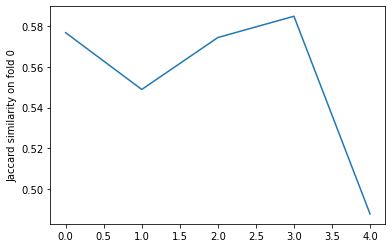

In [ ]:
plt.plot(jaccs_fold0)
plt.ylabel('Jaccard similarity on fold 0')
plt.show()

In [ ]:
print('running first fold')
jaccs_fold1, train_loss_fold1 = run(fold=1)

running first fold

======== Epoch 1 / 4 ========
Training...

  Average training loss: 3.15
  Training epcoh took: 1:00:31

Running Validation...
  Average jaccard similarity on validation data: 0.63
  validation took: 1:00:42
saving model

======== Epoch 2 / 4 ========
Training...

  Average training loss: 2.26
  Training epcoh took: 1:04:09

Running Validation...
  Average jaccard similarity on validation data: 0.66
  validation took: 1:04:20
saving model

======== Epoch 3 / 4 ========
Training...

  Average training loss: 1.97
  Training epcoh took: 1:07:47

Running Validation...
  Average jaccard similarity on validation data: 0.86
  validation took: 1:07:58
saving model

======== Epoch 4 / 4 ========
Training...

  Average training loss: 1.75
  Training epcoh took: 1:11:24

Running Validation...
  Average jaccard similarity on validation data: 0.86
  validation took: 1:11:35


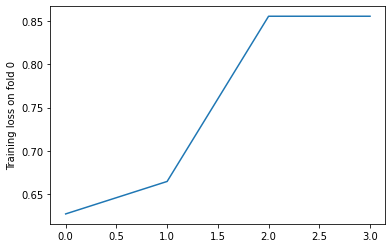

In [ ]:
plt.plot(jaccs_fold1)
plt.ylabel('Average jaccard similarity ')
plt.show()

In [ ]:
print('running second fold')
jaccs_fold2, train_loss_fold2 = run(fold=2)

running second fold

======== Epoch 1 / 4 ========
Training...

  Average training loss: 3.14
  Training epcoh took: 1:43:55

Running Validation...
  Average jaccard similarity on validation data: 0.97
  validation took: 1:44:06
saving model

======== Epoch 2 / 4 ========
Training...

  Average training loss: 2.25
  Training epcoh took: 1:47:33

Running Validation...
  Average jaccard similarity on validation data: 0.97
  validation took: 1:47:44

======== Epoch 3 / 4 ========
Training...

  Average training loss: 1.95
  Training epcoh took: 1:51:09

Running Validation...
  Average jaccard similarity on validation data: 0.97
  validation took: 1:51:20

======== Epoch 4 / 4 ========
Training...

  Average training loss: 1.74
  Training epcoh took: 1:54:45

Running Validation...
  Average jaccard similarity on validation data: 0.97
  validation took: 1:54:56


In [ ]:
print('running 3rd fold')
jaccs_fold3, train_loss_fold3 = run(fold=3)

running 3rd fold

======== Epoch 1 / 3 ========
Training...

  Average training loss: 3.22
  Training epcoh took: 3:04:47

Running Validation...
  Average jaccard similarity on validation data: 0.94
  validation took: 3:04:58
saving model

======== Epoch 2 / 3 ========
Training...

  Average training loss: 2.28
  Training epcoh took: 3:08:26

Running Validation...
  Average jaccard similarity on validation data: 0.94
  validation took: 3:08:37

======== Epoch 3 / 3 ========
Training...

  Average training loss: 2.02
  Training epcoh took: 3:12:02

Running Validation...
  Average jaccard similarity on validation data: 0.94
  validation took: 3:12:13


In [ ]:
print('running 4th fold')
jaccs_fold4, train_loss_fold4 = run(fold=4)

running 4th fold

======== Epoch 1 / 3 ========
Training...

  Average training loss: 3.34
  Training epcoh took: 3:16:45

Running Validation...
  Average jaccard similarity on validation data: 0.92
  validation took: 3:16:56
saving model

======== Epoch 2 / 3 ========
Training...

  Average training loss: 2.34
  Training epcoh took: 3:20:24

Running Validation...
  Average jaccard similarity on validation data: 0.92
  validation took: 3:20:36

======== Epoch 3 / 3 ========
Training...

  Average training loss: 2.06
  Training epcoh took: 3:24:01

Running Validation...
  Average jaccard similarity on validation data: 0.92
  validation took: 3:24:13


In [ ]:
print('running 5th fold')
jaccs_fold5, train_loss_fold5 = run(fold=5)

running 5th fold

======== Epoch 1 / 3 ========
Training...

  Average training loss: 3.18
  Training epcoh took: 3:28:40

Running Validation...
  Average jaccard similarity on validation data: 1.00
  validation took: 3:28:52
saving model

======== Epoch 2 / 3 ========
Training...

  Average training loss: 2.27
  Training epcoh took: 3:32:20

Running Validation...
  Average jaccard similarity on validation data: 1.00
  validation took: 3:32:31

======== Epoch 3 / 3 ========
Training...

  Average training loss: 2.01
  Training epcoh took: 3:35:56

Running Validation...
  Average jaccard similarity on validation data: 1.00
  validation took: 3:36:07


In [ ]:
print('running 6th fold')
jaccs_fold6, train_loss_fold6 = run(fold=6)

running 6th fold

======== Epoch 1 / 3 ========
Training...

  Average training loss: 3.23
  Training epcoh took: 2:44:09

Running Validation...
  Average jaccard similarity on validation data: 0.94
  validation took: 2:44:20
saving model

======== Epoch 2 / 3 ========
Training...

  Average training loss: 2.32
  Training epcoh took: 2:47:47

Running Validation...
  Average jaccard similarity on validation data: 0.94
  validation took: 2:47:58

======== Epoch 3 / 3 ========
Training...

  Average training loss: 2.05
  Training epcoh took: 2:51:22

Running Validation...
  Average jaccard similarity on validation data: 0.94
  validation took: 2:51:33


In [ ]:
print('running 7th fold')
jaccs_fold7, train_loss_fold7 = run(fold=7)

running 7th fold

======== Epoch 1 / 3 ========
Training...

  Average training loss: 3.23
  Training epcoh took: 4:17:31

Running Validation...
  Average jaccard similarity on validation data: 0.66
  validation took: 4:17:42
saving model

======== Epoch 2 / 3 ========
Training...

  Average training loss: 2.29
  Training epcoh took: 4:21:07

Running Validation...
  Average jaccard similarity on validation data: 0.72
  validation took: 4:21:18
saving model

======== Epoch 3 / 3 ========
Training...

  Average training loss: 2.03
  Training epcoh took: 4:24:43

Running Validation...
  Average jaccard similarity on validation data: 0.72
  validation took: 4:24:54


In [ ]:
jaccs = []
losses = []
jaccs.append(np.mean(np.mean(jaccs_fold0)))
jaccs.append(np.mean(jaccs_fold1))
jaccs.append(np.mean(jaccs_fold2))
jaccs.append(np.mean(jaccs_fold3))
jaccs.append(np.mean(jaccs_fold4))
jaccs.append(np.mean(jaccs_fold5))
jaccs.append(np.mean(jaccs_fold6))
jaccs.append(np.mean(jaccs_fold7))

losses.append(np.mean(np.mean(train_loss_fold0)))
losses.append(np.mean(train_loss_fold1))
losses.append(np.mean(train_loss_fold2))
losses.append(np.mean(train_loss_fold3))
losses.append(np.mean(train_loss_fold4))
losses.append(np.mean(train_loss_fold5))
losses.append(np.mean(train_loss_fold6))
losses.append(np.mean(train_loss_fold7))

In [ ]:
print('Jaccard similaritt and train loss average per fold')
data = {'jaccard': jaccs, 'train_loss': losses}
bert_metrics = pd.DataFrame(data)
bert_metrics.to_csv('/content/drive/MyDrive/bert_metrics.csv')
bert_metrics


Jaccard similaritt and train loss average per fold


,jaccard,train_loss
0,0.424733,2.287014
1,0.750644,2.283495
2,0.968182,2.270863
3,0.944664,2.505626
4,0.923554,2.579926
5,1.000000,2.489894
6,0.940559,2.534022
7,0.702253,2.515385


##Testing of modea and Saving the outcomes

we will use outcome of two different models and take their average to find to find the selected text for test data.

In [ ]:
conf = BertConfig.from_pretrained('bert-base-uncased')
conf.output_hidden_states = True

model0 = BERTBaseUncased(conf)
model0.to(device)
model0 = nn.DataParallel(model0)
model0.load_state_dict(torch.load("/content/drive/MyDrive/BERT_files/bert_model0.pth"))

model1 = BERTBaseUncased(conf)
model1.to(device)
model1 = nn.DataParallel(model1)
model1.load_state_dict(torch.load("/content/drive/MyDrive/BERT_files/bert_model1.pth"))

model2 = BERTBaseUncased(conf)
model2.to(device)
model2 = nn.DataParallel(model2)
model2.load_state_dict(torch.load("/content/drive/MyDrive/BERT_files/bert_model2.pth"))

model3 = BERTBaseUncased(conf)
model3.to(device)
model3 = nn.DataParallel(model3)
model3.load_state_dict(torch.load("/content/drive/MyDrive/BERT_files/bert_model3.pth"))

model4 = BERTBaseUncased(conf)
model4.to(device)
model4 = nn.DataParallel(model4)
model4.load_state_dict(torch.load("/content/drive/MyDrive/BERT_files/bert_model4.pth"))

model5 = BERTBaseUncased(conf)
model5.to(device)
model5 = nn.DataParallel(model5)
model5.load_state_dict(torch.load("/content/drive/MyDrive/BERT_files/bert_model5.pth"))

model6 = BERTBaseUncased(conf)
model6.to(device)
model6 = nn.DataParallel(model6)
model6.load_state_dict(torch.load("/content/drive/MyDrive/BERT_files/bert_model6.pth"))

model7 = BERTBaseUncased(conf)
model7.to(device)
model7 = nn.DataParallel(model7)
model7.load_state_dict(torch.load("/content/drive/MyDrive/BERT_files/bert_model7.pth"))

<All keys matched successfully>

In [ ]:
test = config.TEST_FILE.reset_index(drop=True)
test.insert(3,'selected_text', test.text)
test_dataset = TextDataset(text = test.text.values,
                           selected_text = test.selected_text.values,
                           sentiment = test.sentiment.values)

test_dataloader = DataLoader(test_dataset,
                             shuffle=False,
                             batch_size = config.VALID_BATCH_SIZE)
test.head()

,textID,text,sentiment,selected_text
0,f87dea47db,Last session of the day http://twitpic.com/67ezh,neutral,Last session of the day http://twitpic.com/67ezh
1,96d74cb729,Shanghai is also really exciting (precisely -...,positive,Shanghai is also really exciting (precisely -...
2,eee518ae67,"Recession hit Veronique Branquinho, she has to...",negative,"Recession hit Veronique Branquinho, she has to..."
3,01082688c6,happy bday!,positive,happy bday!
4,33987a8ee5,http://twitpic.com/4w75p - I like it!!,positive,http://twitpic.com/4w75p - I like it!!


Calculating final Validation similarity on training data using 3 folds of trained models.

In [ ]:
def final_eval(data_loader):
  model0.eval()
  model1.eval()
  model2.eval()
  model3.eval()
  model4.eval()
  model5.eval()
  model6.eval()
  model7.eval()

  predicted_text = []

  with torch.no_grad():
    for bi, batch in enumerate(data_loader):
      t0 = time.time()
      ids = batch["ids"].to(device, dtype=torch.long)
      token_type_ids = batch['token_type_ids'].to(device, dtype=torch.long)
      attention_mask = batch['attention_mask'].to(device, dtype=torch.long)
      text = batch['text']
      offsets = batch['offsets']
      selected_text = batch['selected_text']
      sentiment = batch['sentiment']
    
      output_start0,output_end0 = model0(ids = ids,
                                         attention_mask = attention_mask,
                                         token_type_ids=token_type_ids)
        
      output_start1,output_end1 = model1(ids = ids,
                                         attention_mask = attention_mask,
                                         token_type_ids=token_type_ids)
      
      output_start2,output_end2 = model2(ids,
                           attention_mask = attention_mask,
                           token_type_ids=token_type_ids)
    
    
      output_start3,output_end3 = model3(ids,
                                         attention_mask = attention_mask,
                                         token_type_ids=token_type_ids)
    
      output_start4,output_end4 = model4(ids,
                                         attention_mask = attention_mask,
                                         token_type_ids=token_type_ids)
    
      output_start5,output_end5 = model5(ids,
                                         attention_mask = attention_mask,
                                         token_type_ids=token_type_ids)

      output_start6,output_end6 = model6(ids,
                                         attention_mask = attention_mask,
                                         token_type_ids=token_type_ids)

      output_start7,output_end7 = model7(ids,
                                         attention_mask = attention_mask,
                                         token_type_ids=token_type_ids)
  
      output_start0 = torch.softmax(output_start0, dim=1).cpu().detach().numpy()
      output_end0 = torch.softmax(output_end0, dim=1).cpu().detach().numpy()

      output_start1 = torch.softmax(output_start1, dim=1).cpu().detach().numpy()
      output_end1 = torch.softmax(output_end1, dim=1).cpu().detach().numpy()

      output_start2 = torch.softmax(output_start2, dim=1).cpu().detach().numpy()
      output_end2 = torch.softmax(output_end2, dim=1).cpu().detach().numpy()

      output_start3 = torch.softmax(output_start3, dim=1).cpu().detach().numpy()
      output_end3 = torch.softmax(output_end3, dim=1).cpu().detach().numpy()

      output_start4 = torch.softmax(output_start4, dim=1).cpu().detach().numpy()
      output_end4 = torch.softmax(output_end4, dim=1).cpu().detach().numpy()

      output_start5 = torch.softmax(output_start5, dim=1).cpu().detach().numpy()
      output_end5 = torch.softmax(output_end5, dim=1).cpu().detach().numpy()

      output_start6 = torch.softmax(output_start6, dim=1).cpu().detach().numpy()
      output_end6 = torch.softmax(output_end6, dim=1).cpu().detach().numpy()

      output_start7 = torch.softmax(output_start7, dim=1).cpu().detach().numpy()
      output_end7 = torch.softmax(output_end7, dim=1).cpu().detach().numpy()

      output_start = (output_start0 + output_start1 +  output_start2 + output_start3+ output_start4 + output_start5 + output_start6 + output_start7) / 8
      output_end = (output_end0 + output_end1 + output_end2 + output_end3 + output_end4 + output_end5 + output_end6 + output_end7) / 8


      for px, tweet in enumerate(text):

        jacc, pred = jaccard_metric(tweet,
                                    selected_text[px],
                                    sentiment = sentiment[px],
                                    offsets = offsets[px,:],
                                    start_idx = np.argmax(output_start[px,]),
                                    end_idx = np.argmax(output_end[px,]))

        predicted_text.append(pred)  
  
  return predicted_text


In [ ]:
print('Testing trained model on test data')
preds = final_eval(test_dataloader)

Testing trained model on test data


In [ ]:
test.selected_text = preds
test.sample(17)

,textID,text,sentiment,selected_text
2970,c7e96d2411,"Uh, happy mother`s day mum.",positive,happy
830,2942ed51f6,Not so much a substitute as a variation. Ate ...,neutral,not so much a substitute as a variation. ate t...
1003,bd499c0bf7,Succesfully following Tayla!!,positive,succesfully
3216,007eeb40ff,http://twitpic.com/4wgoq - The Beach was pheno...,positive,phenomenal 2day
778,50eb2a08c3,Going to Al Ain. Need to check out one store....,positive,hope i find things that i`m looking for.
1282,b8293bb838,"Is on her way to nottingham! ICOF tonight, the...",negative,fail
629,36bc98037c,"yeah, so quick! And I`m using the 5mm addi`s ...",positive,"yeah, so quick! and i`m using the 5mm addi`s i..."
1508,de2a14a465,Last day of CGI 09,neutral,last day of cgi 09
2947,9a6c971e84,"oh okay cool, i love the fast and the furious...",positive,"oh okay cool, i love the fast and the furious ..."
2788,09910a212e,"I am so bored, i really don`t know what to do!",negative,"i am so bored,"


## Saving the submission file

In [ ]:
submission = pd.read_csv('submission.csv')
submission.selected_text = preds
submission = submission.to_csv('submission.csv')

In [ ]:
from google.colab import files
files.download("submission.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>